

# Προγραμματιστική άσκηση:
### Ταξινόμηση καρδιοτοκογραφικών σημάτων με βάση την μεταβλητότητα του καρδιακού ρυθμού


In [39]:
import pandas as pd
import numpy as np  
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import glob
import re
import pyhrv.time_domain as td


In [41]:
"""
* Convert .dat files to .csv
* Create ann_db file for easier processing of additional annotations
"""
#%run create_csv_database.py
# %df_init.py

'\n* Convert .dat files to .csv\n* Create ann_db file for easier processing of additional annotations\n'

In [42]:
import pathlib
total_signals = 0
for path in pathlib.Path("./database/signals").iterdir():
    if path.is_file():
        total_signals += 1
print("Total signals:",total_signals)

Total signals: 553


<h5>Διαβασμα πρόσθετων πληροφοριών για κάθε σήμα (*2)</h5>

In [43]:
ann_db = pd.read_csv("database/ann_db.csv")
ann_db.rename(columns={'Unnamed: 0':'Labels'}, inplace=True)
ann_db = ann_db.set_index('Labels')
ann_db.index

Index(['pH', 'BDecf', 'pCO2', 'BE', 'Apgar1', 'Apgar5', 'NICU days',
       'Seizures', 'HIE', 'Intubation', 'Main diag.', 'Other diag.',
       'Gest. weeks', 'Weight(g)', 'Sex', 'Age', 'Gravidity', 'Parity',
       'Diabetes', 'Hypertension', 'Preeclampsia', 'Liq.', 'Pyrexia',
       'Meconium', 'Presentation', 'Induced', 'I.stage', 'NoProgress', 'CK/KP',
       'II.stage', 'Deliv. type', 'dbID', 'Rec. type', 'Pos. II.st.',
       'Sig2Birth'],
      dtype='object', name='Labels')

# Data Description:
#### A short (non medically exhaustive) description of the feature meaning

**analysis of umbilical artery blood sample**
- **pH** : Is the ph of the blood of the baby (n.v. 7.35-7.45). A slight increase causes blood alkalosis while a slight decrease causes acidosis. Both conditions are extremely life threatening. This value is inverse proportional to **pCO2**.
- **BDecf** : Base excess of extracellular fluid is a quantity that reflects only the non-respiratory (metabolic) component of acid-base disturbances. (Reference : [Here](https://acutecaretesting.org/en/articles/all-about-base-excess--to-be-or-not-to-be))
- **pCO2** : is the relative pressure of CO2 in the blood (n.v. 4.5-6.0Kpa). In Respiratory Acidosis, **pH** and **pCO2** are inverse proportional while in Metabolic Acidosis they are directly proportional.
- **BE** : is the excess or deficit (if negative) of bases in the blood (e.g. HCO3). The normal range is between -2 and +2 mEq/L or mmol/L. A value above the range is indicative of Metabolic Alkalosis while below the range is indicative of Metabolic Acidosis.

- **Apgar1** : It's the Apgar score at 1min from birth. It indicates the overall health status of the baby at birth. It can have values between 0 and 10 where a score above 7 is considered good. (Reference and table : [Here](https://www.birthinjurysafety.org/birth-injuries/apgar-scoring-system.html))
- **Apgar5** : It's the Apgar score at 5min from birth. See **Apgar1**.
- **Gest. weeks** : It's the number of weeks of gestation where 39-40 weeks represent a normal term delivery.
- **Weight(g)** : Is the weigth of the baby in grams at birth. This is various but in general the normal range would be between 2500g and 4500g.
- **Sex** : This is a boolean for 1 and 2 where is not clear which is male/female but shouldn't matter.
- **Age** : The Age in years of the mom.
- **Gravidity** : Is the number of times the woman has been pregnant in her life.
- **Parity** : Is the number of times the woman has been pregnant for more than 24 weeks (in a single pregnancy).
- **Diabetes** : Boolean value for Diabetes of 0 (False) and 1 (True).
- **Hypertension** : Boolean value for Hypertension of 0 (False) and 1 (True).
- **Preeclampsia** : Boolean value for Preeclampsia of 0 (False) and 1 (True). where Preeclampsia indicate a disorder of pregnancy that could lead to complications.
- **Liq.** : It referes to Liquor which in this case is the Amniotic Fluid. <mark>I'm not sure why is a boolean in the data.</mark>
- **Pyrexia** : Is a boolean value that indicate the presence of pyrexia (high temperature) in the mom or not.
- **Meconium** : Is a boolean value that indicate the presence or not of Meconium which is the earliest stool of the baby that could happen before partum.
- **Presentation** : <mark>This indicate the presentation of the baby during delivery which can be head first, legs first etc. The problem here is that this value is a number which most probably refers to an internal classification or a scale I don't know how to interpret. **See also Deliv. type**</mark>
- **Induced** : Is a boolean value that indicate if the delivery has been medically induced.
- **I.stage** : <mark>It should indicate the time in between contractions in the stage of the delivery but this is only my observational opinon based on the data.</mark>
- **NoProgress** : Is a boolean value that indicate if there has been an abort of the pregnancy or not.
- **CK/KP** : <mark>It should refer to the level of Creatine Kinase?</mark>
- **II.stage** : <mark>see **I.stage**.</mark>
- **Deliv. type** : <mark>(1: vaginal; 2: operative vaginal; 3: CS)</mark>
- **dbID** : is just an ID of the record
- **Rec. type** : <mark>No idea</mark>
- **Pos. II.st.** : <mark>No idea</mark>

In [44]:
def open_dataframe():
    # specifying the path to csv files
    path = "database/signals"
    # csv files in the path
    files = glob.glob(path + "/*.csv")

    # defining an empty list to store content
    data_frame = pd.DataFrame()

    # checking all the csv files in the specified path
    for filename in files:
        name = re.sub("[^0-9]", "", filename)
        df = pd.read_csv(filename, index_col=None)
        data_frame = data_frame.append(
            {
                'tag': name,
                'Fhr': list(df['FHR']), 
                'UC': df['UC'],
                'labels': ann_db[name]
            },
            ignore_index=True
        )
    return data_frame


In [45]:
def reset_index(data_frame):
    return data_frame.reset_index().drop('index', axis=1)

<h5>Δεν λήφθηκαν υπόψιν τα σήματα όπου αφορούσαν
περιπτώσεις καισαρικής τομής. Είναι πολύ πιθανό σε αυτά τα 46 σήματα 
να υπήρχε ήδη διάγνωση για κάποιο παθολογικό πρόβλημα, 
συνεπώς αυτό το γεγονός θα επηρέαζε τα αποτελέσματα των
μεθόδων.</h5>

In [96]:
def drop_restictions(df):
    records_to_drop = list()
    cc = ca = cd = cw = 0
    
    for i in range(df.shape[0]):
        if (df.iloc[i]['labels']['Deliv. type'] != 1.0):
            records_to_drop.append(i); cc+=1

        if (df.iloc[i]['labels']['Age'] < 18):
            records_to_drop.append(i); ca+=1

        if (df.iloc[i]['labels']['Hypertension'] == 1 or
            df.iloc[i]['labels']['Preeclampsia'] == 1 or 
            df.iloc[i]['labels']['Diabetes'] == 1):
            records_to_drop.append(i); cd+=1

        if (df.iloc[i]['labels']['Gest. weeks'] < 37.5):
            records_to_drop.append(i); cw+=1
            
    print(cw,' underweeked records dropped')
    print(cd,' diseased records dropped')
    print(ca,' underage records dropped')
    print(cc,' casarean records dropped')
    
    print(len(records_to_drop), 'total records dropped')
    return reset_index(df.drop(records_to_drop))

data_frame = open_dataframe()
data_frame_init = drop_restictions(data_frame)
data_frame_init 

18  underweeked records dropped
86  diseased records dropped
0  underage records dropped
46  casarean records dropped
150 total records dropped


,Fhr,UC,labels,tag
0,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",0 26.0 1 26.0 2 25.5 3 ...,Labels pH 7.00 BDecf ...,1002
1,"[137.5, 137.5, 137.5, 139.5, 139.5, 140.75, 14...",0 0.0 1 0.0 2 0.0 3 ...,Labels pH 7.20 BDecf ...,1003
2,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",0 46.0 1 43.0 2 43.0 3 ...,Labels pH 7.30 BDecf ...,1004
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.0 1 0.0 2 0.0 3 ...,Labels pH 7.30 BDecf ...,1005
4,"[143.5, 142.75, 142.75, 142.75, 142.75, 141.5,...",0 0.0 1 0.0 2 0.0 3 ...,Labels pH 7.23 BDecf ...,1006
...,...,...,...,...
410,"[0.0, 0.0, 84.25, 84.25, 84.25, 82.25, 82.25, ...",0 22.5 1 24.0 2 25.5 3 ...,Labels pH 7.26 BDecf ...,1502
411,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 21.5 1 18.0 2 34.5 3 ...,Labels pH 7.31 BDecf ...,1503
412,"[141.0, 141.25, 141.25, 141.0, 141.0, 141.0, 1...",0 20.0 1 20.0 2 19.5 3 ...,Labels pH 7.28 BDecf ...,1504
413,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.0 1 0.0 2 0.0 3 ...,Labels pH 7.24 BDecf ...,1505


* The maximum missing value in FHR is 53.50% and average is 18.78%. 
* We can't delete any timestamp because deleting it would change the length of each signal. 
* So instead of deletion the 0 values have been filled with rolling mean with a window of 100 previous timestamps.

In [97]:
def drop_noisy_records(df, thresh=0.2):
    noisy_records = list()
    
    for i in range(df.shape[0]):
        record = df.iloc[i]
        perc_zeros = record['Fhr'].count(0) / len(record['Fhr'])
        if( perc_zeros > thresh ):
            noisy_records.append(i)    
    return  reset_index(df.drop(noisy_records))

In [98]:
SEGMENT_SIZE = 25 # megalo SEGMENT_SIZE -> ligotero strict
NOISY_THRESH = 0.20 # mikro NOISY_THRESH -> eimaste  strict
NOISE_RETRV_THRESH = 0.25 # mikro NOISE_RETRV_THRESH -> poly smoothing
N_PREV_VALS = 10

In [99]:
data_frame = drop_noisy_records(data_frame_init,thresh=NOISY_THRESH)
data_frame

,Fhr,UC,labels,tag
0,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",0 26.0 1 26.0 2 25.5 3 ...,Labels pH 7.00 BDecf ...,1002
1,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",0 46.0 1 43.0 2 43.0 3 ...,Labels pH 7.30 BDecf ...,1004
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 18.0 1 19.0 2 19.5 3 ...,Labels pH 7.36 BDecf ...,1008
3,"[149.5, 149.75, 149.75, 150.0, 150.0, 150.25, ...",0 12.0 1 11.5 2 11.5 3 ...,Labels pH 7.37 BDecf ...,1011
4,"[145.0, 145.0, 146.0, 145.5, 145.5, 146.5, 146...",0 7.5 1 7.5 2 7.5 3 ...,Labels pH 7.14 BDecf ...,1014
...,...,...,...,...
229,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.0 1 0.0 2 0.0 3 ...,Labels pH 7.24 BDecf ...,1499
230,"[0.0, 0.0, 84.25, 84.25, 84.25, 82.25, 82.25, ...",0 22.5 1 24.0 2 25.5 3 ...,Labels pH 7.26 BDecf ...,1502
231,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 21.5 1 18.0 2 34.5 3 ...,Labels pH 7.31 BDecf ...,1503
232,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 0.0 1 0.0 2 0.0 3 ...,Labels pH 7.24 BDecf ...,1505


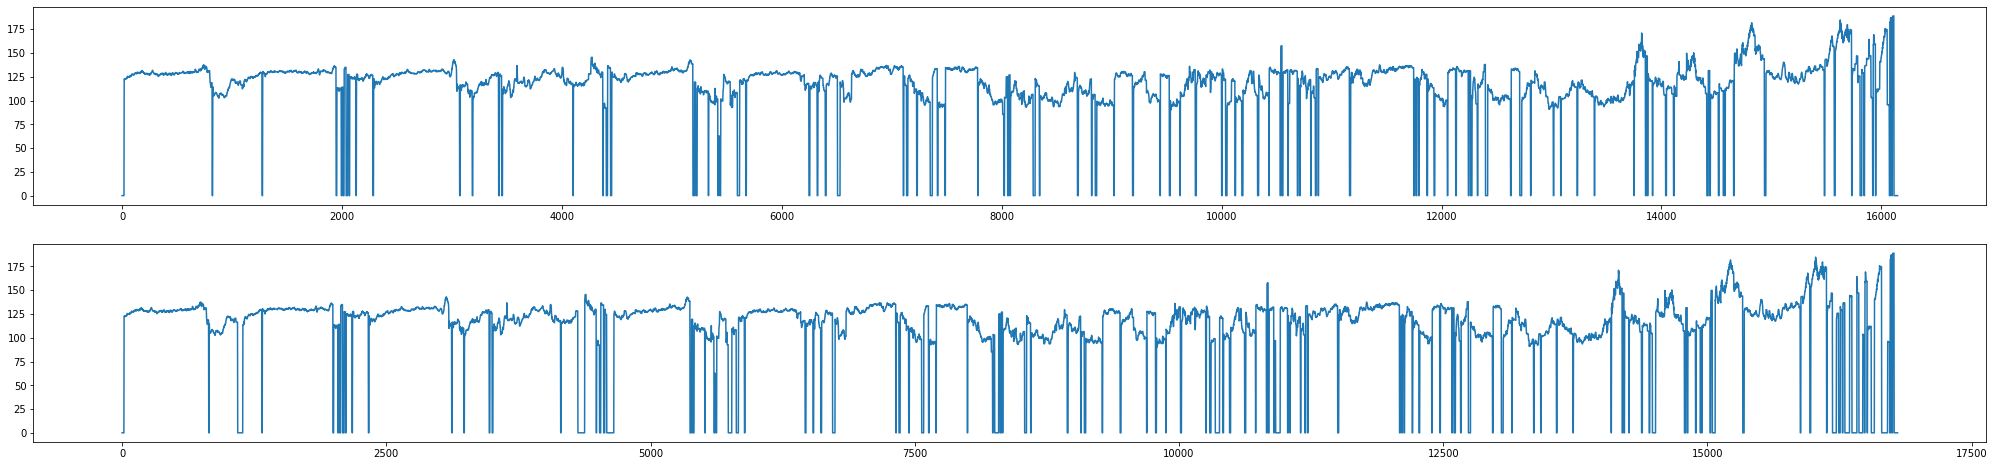

In [69]:
def drop_zero_segments(df_input, segment_size = 20):
    df = df_input.copy()
    
    for row_i , fhr in df_input['Fhr'].iteritems():
        fhr_list = list(fhr) # get fhr of record row_i as list
        fhr_list_out = list() # set an empty list
        count = 0
        for j, value in enumerate(fhr_list):     
            if(value == 0):
                count += 1                
            else:
                if(count >= segment_size):
                    fhr_list_out = fhr_list_out[:-count]
                count = 0    
            fhr_list_out.append(value)
        df.at[row_i, 'Fhr'] = fhr_list_out
        
    return df

df2 = drop_zero_segments(data_frame, segment_size=SEGMENT_SIZE)
df2 = df2.set_index('tag')
df0 = data_frame.set_index('tag')

fig,ax = plt.subplots(2,1, figsize=(35,8))
ax[0].plot(df2.loc['1008']['Fhr'])
ax[1].plot(df0.loc['1008']['Fhr'])

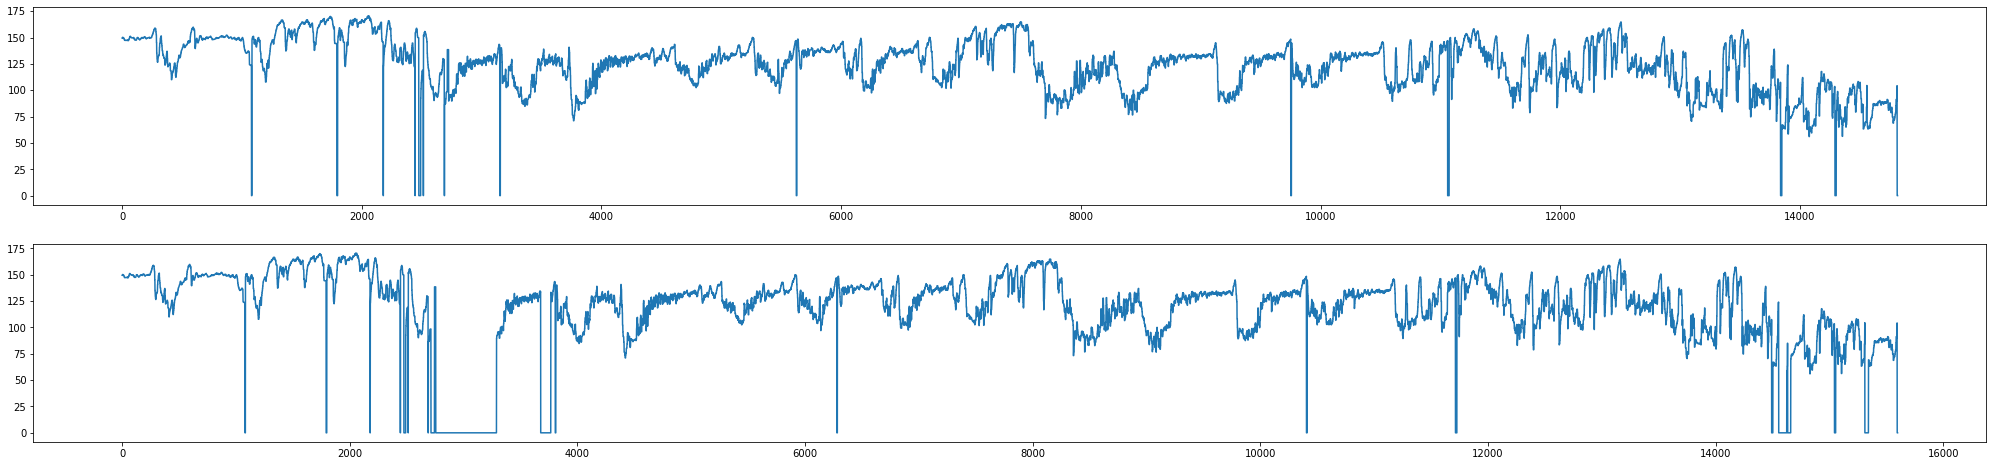

In [70]:
fig,ax = plt.subplots(2,1, figsize=(35,8))
ax[0].plot(df2.iloc[3]['Fhr'])
ax[1].plot(data_frame.iloc[3]['Fhr'])

In [71]:
def df_to_ms(df_input):    
    '''
    Convert bpm to miliseconds
    '''
    df = df_input.copy()
    for row_i, fhr in df['Fhr'].iteritems():
        fhr_ms = [60000 / x if x != 0.0 else 0.0 for x in fhr]
        df.at[row_i, 'Fhr'] = fhr_ms
    return df 

df3 = df_to_ms(df2)
df3.head()

,Fhr,UC,labels
tag,,,
1002,"[410.2564102564103, 410.2564102564103, 399.334...",0 26.0 1 26.0 2 25.5 3 ...,Labels pH 7.00 BDecf ...
1004,"[390.2439024390244, 390.2439024390244, 390.243...",0 46.0 1 43.0 2 43.0 3 ...,Labels pH 7.30 BDecf ...
1008,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0 18.0 1 19.0 2 19.5 3 ...,Labels pH 7.36 BDecf ...
1011,"[401.33779264214047, 400.6677796327212, 400.66...",0 12.0 1 11.5 2 11.5 3 ...,Labels pH 7.37 BDecf ...
1014,"[413.7931034482759, 413.7931034482759, 410.958...",0 7.5 1 7.5 2 7.5 3 ...,Labels pH 7.14 BDecf ...


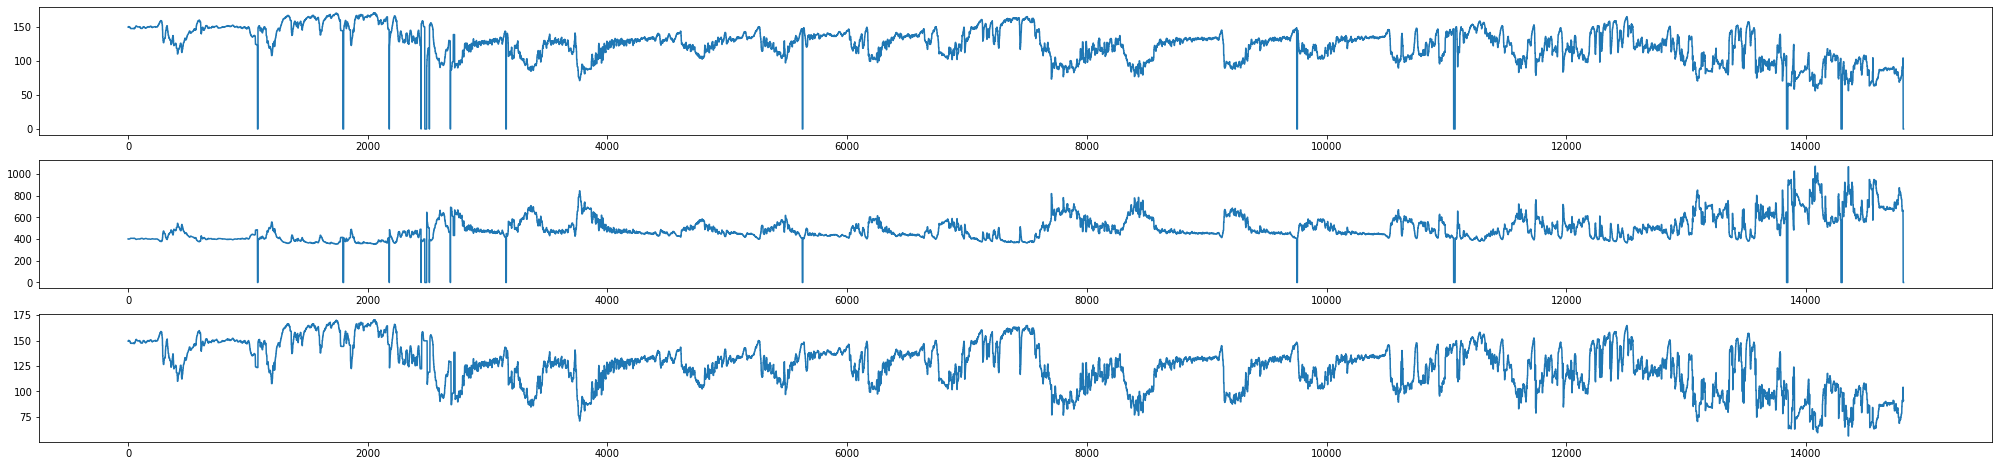

In [72]:
from statistics import median 

def get_median(lst, index, n_prev_vals):
    medians = list()
    for i in range(index, 0, -1):
        if(lst[i] != 0):
            medians.append(lst[i])
        if(len(medians)==n_prev_vals):
            return median(medians)

    return median(lst)
            
def noise_retrieval(df_input, thres = 0.25, n_prev_vals=3):
    df = df_input.copy()
    for row_i , fhr in df['Fhr'].iteritems():
        fhr_new = list()
        for i in range(len(fhr)):
            prev_values_med = get_median(fhr, i, n_prev_vals)
            if(fhr[i] > prev_values_med + prev_values_med * thres or 
            fhr[i] < prev_values_med - prev_values_med * thres ):
                fhr_new.append(prev_values_med)
            else: 
                fhr_new.append(fhr[i])
        df.at[row_i,'Fhr'] = fhr_new
        
    return df 

df4 = noise_retrieval(df2, thres=NOISE_RETRV_THRESH, n_prev_vals=N_PREV_VALS)

fig,ax = plt.subplots(3,1, figsize=(35,8))
ax[0].plot(df2.iloc[3]['Fhr'])
ax[1].plot(df3.iloc[3]['Fhr'])
ax[2].plot(df4.iloc[3]['Fhr'])

In [73]:

def compute_hrv(df_input):
    df = df_input.copy()
    
    methods_names = ['sdnn', 'rmssd', 'sdann', 'nn20', 'nn50']
    df['HRV_res'] = [dict(zip(methods_names, [None]*len(methods_names))) for i in range(df.shape[0])]
    
    for row_i, fhr in tqdm(df['Fhr'].iteritems(), total=df.shape[0]):
        
        df.loc[row_i]['HRV_res']['sdnn'] = td.sdnn(np.array(df.loc[row_i]['Fhr']))
        df.loc[row_i]['HRV_res']['rmssd'] = td.rmssd(np.array(df.loc[row_i]['Fhr']))
        df.loc[row_i]['HRV_res']['sdann'] = td.sdann(np.array(df.loc[row_i]['Fhr']))
        df.loc[row_i]['HRV_res']['nn20'] = td.nn20(np.array(df.loc[row_i]['Fhr']))
        df.loc[row_i]['HRV_res']['nn50'] = td.nn50(np.array(df.loc[row_i]['Fhr']))
        
    return df 

df5 = compute_hrv(df4)
df5.head()


100%|██████████| 234/234 [09:21<00:00,  2.40s/it]


,Fhr,UC,labels,HRV_res
tag,,,,
1002,"[146.25, 146.25, 150.25, 148.5, 148.5, 143.5, ...",0 26.0 1 26.0 2 25.5 3 ...,Labels pH 7.00 BDecf ...,"{'sdnn': (24.151511535297974,), 'rmssd': (2.78..."
1004,"[153.75, 153.75, 153.75, 154.75, 154.75, 153.7...",0 46.0 1 43.0 2 43.0 3 ...,Labels pH 7.30 BDecf ...,"{'sdnn': (22.21615385507634,), 'rmssd': (1.894..."
1008,"[124.0, 124.0, 124.0, 124.0, 124.0, 124.0, 124...",0 18.0 1 19.0 2 19.5 3 ...,Labels pH 7.36 BDecf ...,"{'sdnn': (14.888796067991317,), 'rmssd': (2.23..."
1011,"[149.5, 149.75, 149.75, 150.0, 150.0, 150.25, ...",0 12.0 1 11.5 2 11.5 3 ...,Labels pH 7.37 BDecf ...,"{'sdnn': (22.151290463333712,), 'rmssd': (2.80..."
1014,"[145.0, 145.0, 146.0, 145.5, 145.5, 146.5, 146...",0 7.5 1 7.5 2 7.5 3 ...,Labels pH 7.14 BDecf ...,"{'sdnn': (23.719983988141312,), 'rmssd': (2.86..."


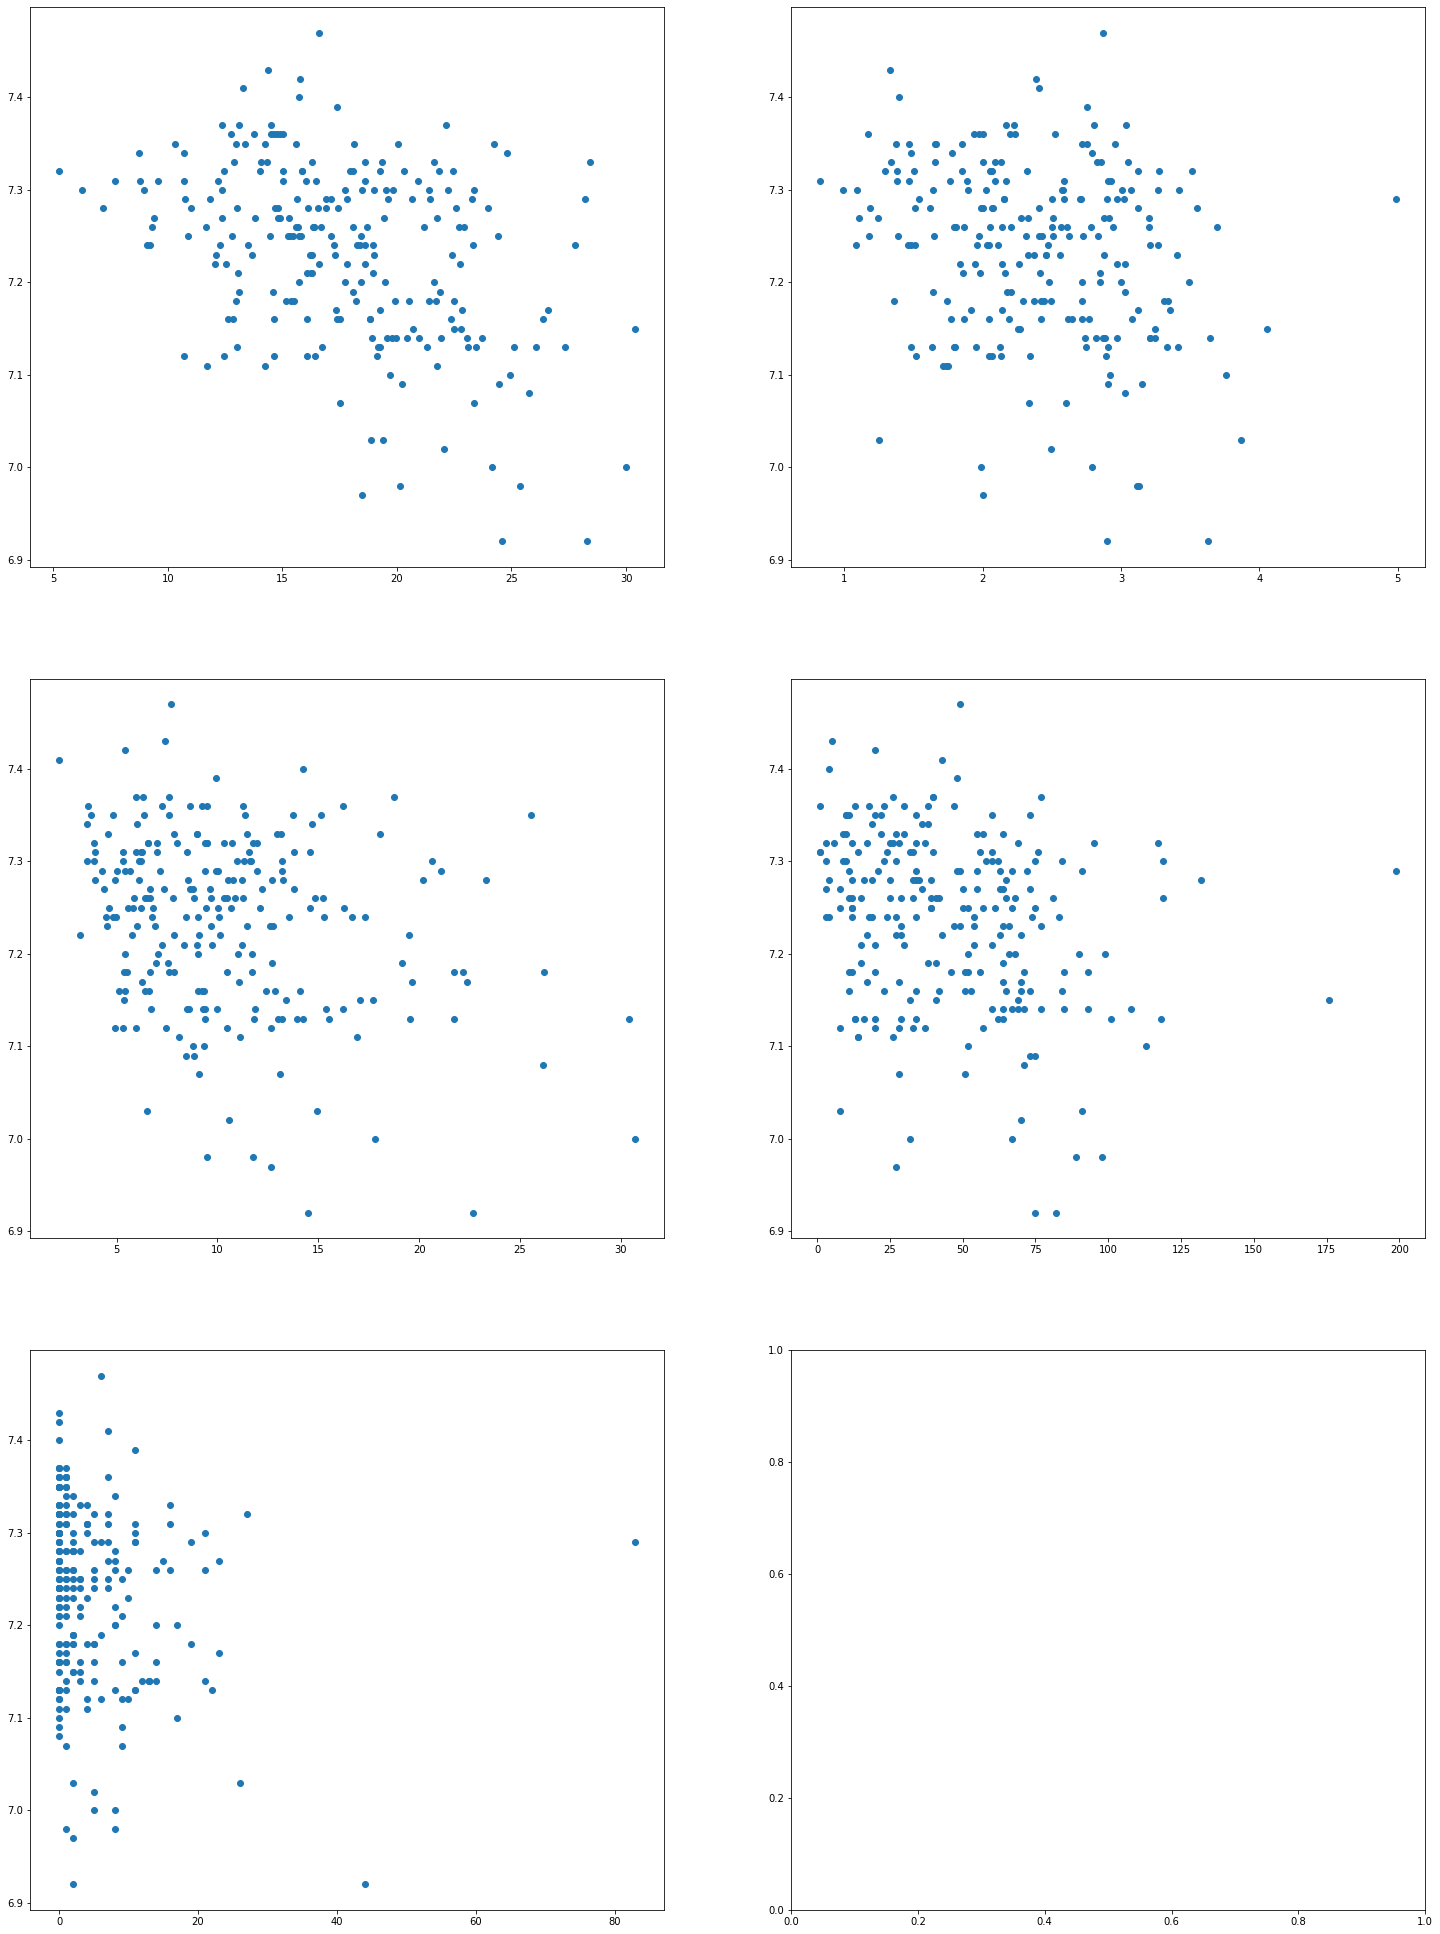

In [76]:
fig,ax = plt.subplots(3,2, figsize=(25,35))
ax[0][0].scatter([hrv_val['sdnn'][0] for _, hrv_val in df5['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df5['labels'].iteritems()])
ax[0][1].scatter([hrv_val['rmssd'][0] for _, hrv_val in df5['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df5['labels'].iteritems()])
ax[1][0].scatter([hrv_val['sdann'][0] for _, hrv_val in df5['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df5['labels'].iteritems()])
ax[1][1].scatter([hrv_val['nn20'][0] for _, hrv_val in df5['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df5['labels'].iteritems()])
ax[2][0].scatter([hrv_val['nn50'][0] for _, hrv_val in df5['HRV_res'].iteritems()] , [hrv_val['pH'] for _, hrv_val in df5['labels'].iteritems()])

# for row_i, hrv_val in df5['HRV_res'].iteritems():
#     print(row_i, hrv_val['sdnn'][0] )

In [77]:
from scipy.stats import pearsonr, spearmanr, kendalltau
results = {'sdnn': [], 'rmssd': [], 'sdann': [], 'nn20': [], 'nn50': []}


for method_name in results.keys():
    results[method_name].append( 
        pearsonr(
            [hrv_val[method_name][0] for _, hrv_val in df5['HRV_res'].iteritems()] ,
            [hrv_val['pH'] for _, hrv_val in df5['labels'].iteritems()]
        )[0]
    )
    results[method_name].append( 
        spearmanr(
            [hrv_val[method_name][0] for _, hrv_val in df5['HRV_res'].iteritems()] ,
            [hrv_val['pH'] for _, hrv_val in df5['labels'].iteritems()]
        )[0]
    )
    results[method_name].append( 
        kendalltau(
            [hrv_val[method_name][0] for _, hrv_val in df5['HRV_res'].iteritems()] ,
            [hrv_val['pH'] for _, hrv_val in df5['labels'].iteritems()]
        )[0]
    )

results

{'sdnn': [-0.3956767229875423, -0.3630261830842476, -0.2544193541309007],
 'rmssd': [-0.22905412563779895, -0.21662109804196714, -0.1469423631665653],
 'sdann': [-0.2706068641927098, -0.21596877588695956, -0.14738956285157645],
 'nn20': [-0.2453256683229023, -0.26355613281804574, -0.18263904182695442],
 'nn50': [-0.15709443578063587, -0.21244894265176276, -0.15343781448579197]}